# Customers' Segmentation - Clustering Analysis

In this study, we would like to implement the following clustering methods to analyze different clusters from our data: dissimilarity methods and model-based methods. These methods is performed on **Mall Customers' Segmentation** data. The data set can be obtained through the [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

Malls often try to increase their customer flows and make a huge profit during their visits to the store. By conducting the clustering methods that we chose, a comparison can be made to see which clustering method provides the most insight from the raw dataset. In addition, the generated results can be provided to the marketing team so that they can plan the strategy accordingly.

## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gower  # pip install gower
from kmodes.kprototypes import KPrototypes  # pip install kmodes
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('ggplot')
%matplotlib inline

# 1. Descriptive Analysis of data

In [2]:
# import data
df = pd.read_csv(r'D:\Western University\B-term\Advanced Data Analysis\Final Project\Data\Mall_Customers.csv')
df.columns = ['CustomerID', 'Gender', 'Age', 'Income', 'SpendingScore']

In [3]:
# convert object to category
df['Gender'] = pd.Series(df['Gender'], dtype="category")

# remove customer ID
df = df.drop(columns=['CustomerID'])

In [4]:
df.info()  # summary of the data
print('-'*45)
print('Data shape: ', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Gender         200 non-null    category
 1   Age            200 non-null    int64   
 2   Income         200 non-null    int64   
 3   SpendingScore  200 non-null    int64   
dtypes: category(1), int64(3)
memory usage: 5.1 KB
---------------------------------------------
Data shape:  (200, 4)


In [5]:
round(df.describe(),3)

Age   Income  SpendingScore
count  200.000  200.000        200.000
mean    38.850   60.560         50.200
std     13.969   26.265         25.824
min     18.000   15.000          1.000
25%     28.750   41.500         34.750
50%     36.000   61.500         50.000
75%     49.000   78.000         73.000
max     70.000  137.000         99.000

In [6]:
# duplicate observations
duplicate_rows_df = df[df.duplicated()]
print('number of duplicate rows: ', duplicate_rows_df.shape)

number of duplicate rows:  (0, 4)


In [7]:
# Null values
df.isnull().sum()

Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64

We saw that there is no duplicate values as well as missing values.

In [8]:
# columns' name
df.columns

Index(['Gender', 'Age', 'Income', 'SpendingScore'], dtype='object')

# 2. Exploratory Data Analysis

### 2.1 Gender

Text(0.5, 1.0, 'Gender Proportion')

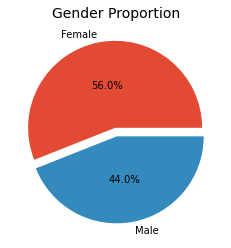

In [9]:
# Gender frequency
plt.pie(x=df['Gender'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels = ['Female', 'Male'], pctdistance=0.5)
plt.title("Gender Proportion", fontsize=14)

As can be seen, 44% of shoppers are male while 56% of them are female.

### 2.2 Age

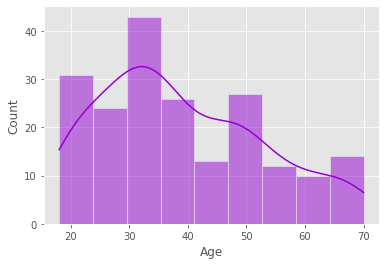

In [10]:
# Customers by Age
sns.histplot(data=df['Age'], kde=True, color='darkviolet')

Age is an integer number that bounded between 18 to 70 in our data set. The plot shows that the most customers are young.

### 2.3 Income

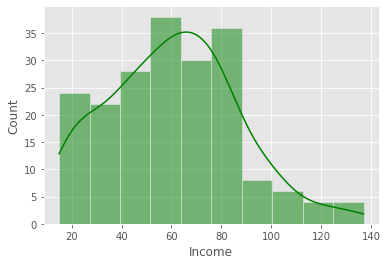

In [11]:
# Customers by Income
sns.histplot(data=df['Income'], kde=True, color='green')

We can see that fewer customers have an annual income above 80k dollars.

### 2.4 Spending Score

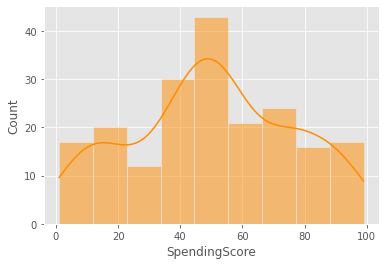

In [12]:
# Customers by Spendig Score
sns.histplot(data=df['SpendingScore'], color='darkorange', kde=True)

The plot shows that most customers have a spending score in the first quarter, and third quarter, especially around 50. This finding represents that the mall caters to a variety of customers with various needs available in the mall.

### 2.5 Male and Female customers based on different variables

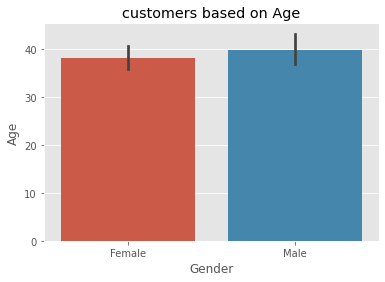

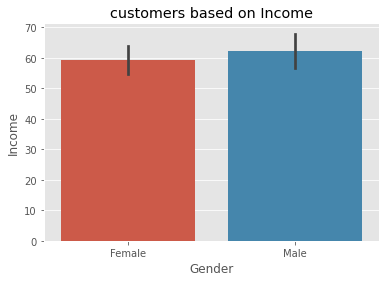

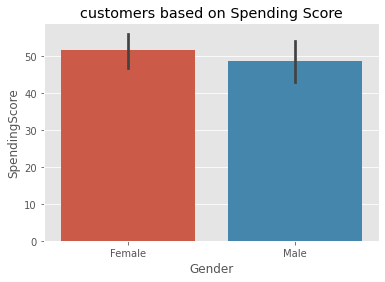

In [13]:
sns.barplot(x='Gender', y='Age', data=df)
plt.title('customers based on Age')
plt.show()
sns.barplot(x='Gender', y='Income', data=df)
plt.title('customers based on Income')
plt.show()
sns.barplot(x='Gender', y='SpendingScore', data=df)
plt.title('customers based on Spending Score')
plt.show()

On average, men are older than women. While men have the highest income compared to women, women have more spending score at the mall.

### 2.6 correlations between variables

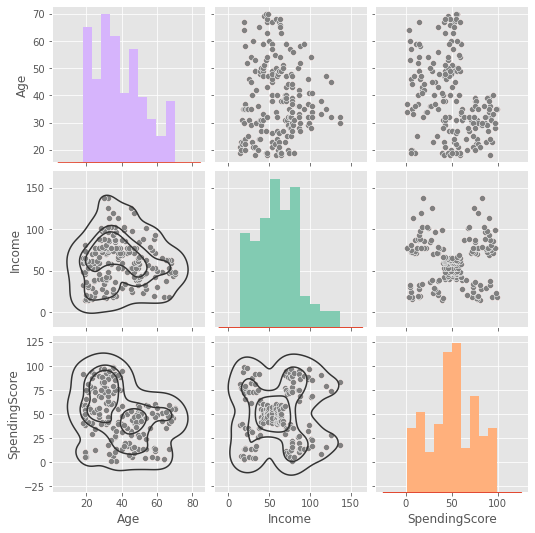

In [14]:
# relationship between variables by correlation matrix
colors=iter(['xkcd:light violet', 'xkcd:pale teal', 'xkcd:peach'])
def my_hist(x, **kwargs):
    kwargs['color'] = next(colors)
    plt.hist(x, **kwargs)


r = sns.pairplot(df, kind='scatter', diag_kind='kde')
r.map_diag(my_hist)
r.map_upper(sns.scatterplot,color='grey')
r.map_lower(sns.scatterplot,color='grey')
r.map_lower(sns.kdeplot, levels=4, color=".2")

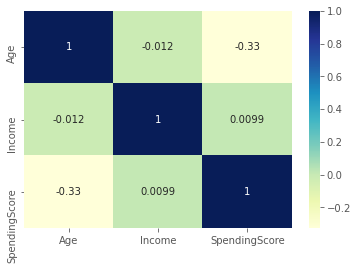

In [15]:
# heatmap plot shows the correlations between continues variables
cor = df.corr()
sns.heatmap(cor, cmap='YlGnBu', annot=True)

Obviously, there are no strong/semi-strong correlations between variables.

### 2.7 deeper look at the Annual Income and Spending Score relations

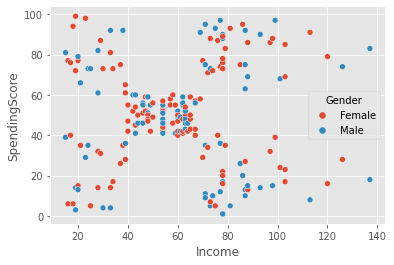

In [16]:
# First scatter plot is drawn based on Gender
sns.scatterplot(x=df['Income'], y=df['SpendingScore'] , hue=df['Gender'])

As we can see from the above plot, Gender may be distributed normally in all part of the scatter plot.

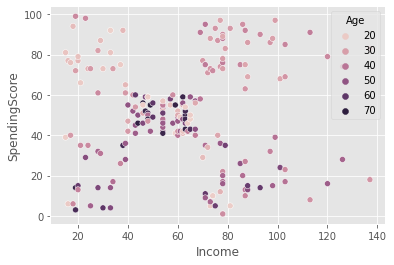

In [17]:
# Second scatter plot is drawn based on Age
sns.scatterplot(x=df['Income'], y=df['SpendingScore'] , hue=df['Age'])

We can see from the above plot that the spending score for most aged customers is up to around 60. It also seems that customers between 30 to 40 years old have more income and more spending score.

# 3. Methods

## 3.1 Dissimilarity-based methods

Dissimilarity-based methods work directly on the observed data with no direct reference to an underlying probability model. In this part, we employ KMeans, Hierarchical Clustering and K-prototypes algorithms for cluster analysis in our study.

### 3.1.1 KMeans

K-means algorithm is one of the more common clustering algorithms used in unsupervised machine learning due to its simplicity. K-means works by identifying k numbers of centroids (centers of cluster) and allocates every single observation to the nearest cluster. It is also an iterative algorithm that makes the intracluster data points as close as possible while also differentiate the clusters as distinct as possible. It assigns data points to a cluster that has the minimum sum of the squared distance between the data points and the clusters’ centroid. The low value of variance within the clusters indicates the homogeneity of the data points within the same cluster.

Continuous variables should be standardized/normalized in dissimilary methods.

Furthermore, it is important to determine the most optimal number of clusters. It can be calculated by using "elbow method", "silhouette", and etc.

In [18]:
# standardize data
dfs = StandardScaler().fit_transform(df[['Age', 'Income', 'SpendingScore']])
dfs = pd.DataFrame(dfs, columns=['Age', 'Income', 'SpendingScore'])

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mosta\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\mosta\anaconda3\lib\site-packages\seaborn\relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


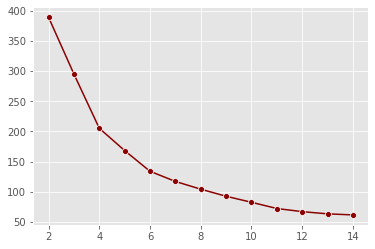

In [19]:
# determine best number of clusters using intertia
np.random.seed(0)
Score = []

for k in range( 2 , 15):
    ClusterModel = KMeans(n_clusters=k).fit(dfs)
    Score.append(ClusterModel.inertia_)

sns.lineplot(range( 2 ,15), Score, marker='o', c='darkred')

As we can see from the elbow plot, the best number of clusters using KMeans would be 4 to 6. We will take a look at the silhouette core for different number of clusters to make sure about that.

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mosta\anaconda3\lib\site-packages\seaborn\relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
C:\Users\mosta\anaconda3\lib\site-packages\seaborn\relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


Text(0.5, 1.0, 'silhouette score')

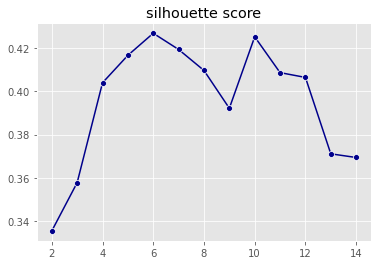

In [20]:
# determine best number of clusters using silhouette
Sscore = []

for k in range(2, 15):
    ClusterModel = KMeans(n_clusters=k).fit(dfs)
    Sscore.append(silhouette_score(dfs, ClusterModel.labels_, metric='euclidean'))


sns.lineplot(range( 2 ,15), Sscore, marker='o', c='darkblue')
plt.title('silhouette score')

When silhouette score is close to 1, we can say that is good. So, the plot confirmed that the best number of clusters is 6 for KMeans algorithm.

In [21]:
# fit the model with k = 6
np.random.seed(0)
km = KMeans(n_clusters=6)
km.fit(dfs)

# add predicted clusters to the data 
km_labels = km.predict(dfs)
df['km_cluster'] = km_labels
df.columns = ['Gender', 'Age', 'Income', 'SpendingScore', 'km_cluster']

# number of obs in each cluster
df['km_cluster'].value_counts()

2    45
3    39
4    38
0    34
1    23
5    21
Name: km_cluster, dtype: int64

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


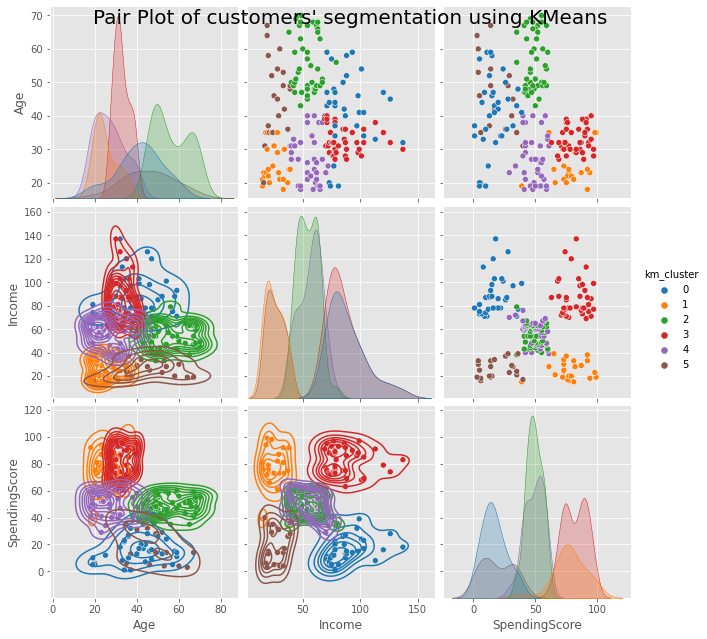

In [22]:
# pair plot on different features, colored by km_cluster
ax = sns.pairplot(df, hue = 'km_cluster', height = 3, palette='tab10')
ax.map_lower(sns.kdeplot, level=4)
plt.suptitle("Pair Plot of customers' segmentation using KMeans", size = 20)
plt.show()

In [23]:
# 3-D view
fig = px.scatter_3d(data_frame=df, x='Age', y='Income', z='SpendingScore', color='km_cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [24]:
# clusters' characteristics
round(df.groupby(['km_cluster', 'Gender'])[['Age', 'Income', 'SpendingScore']].mean(), 3)

Age  Income  SpendingScore
km_cluster Gender                               
0          Female  43.786  93.286         20.643
           Male    39.500  85.150         14.050
1          Female  25.462  25.692         80.538
           Male    24.400  24.700         73.800
2          Female  54.154  54.231         48.962
           Male    59.316  54.316         49.211
3          Female  32.190  86.048         81.667
           Male    33.278  87.111         82.667
4          Female  27.960  57.360         47.120
           Male    25.154  55.308         53.000
5          Female  41.538  26.538         20.692
           Male    52.000  25.875         17.250

In a nutshell, our six clusters are defined as:
- **Cluster 1**: Men and women around 41.3 years old with average 88.5K annual income and spending score of 16.8 out of 100.
- **Cluster 2**: Men and women around 25.0 years old with average 25.3K annual income and spending score of 77.6 out of 100.
- **Cluster 3**: Men and women around 56.3 years old with average 54.3K annual income and spending score of 49.1 out of 100.
- **Cluster 4**: Men and women around 32.7 years old with average 86.5K annual income and spending score of 82.1 out of 100.
- **Cluster 5**: Men and women around 27.0 years old with average 56.7K annual income and spending score of 49.1 out of 100.
- **Cluster 6**: Men and women around 45.5 years old with average 26.3K annual income and spending score of 19.4 out of 100.

### 3.1.2 Hierarchical Clustering

Hierarchical Clustering, known as Agglomerative clustering, is a powerful, flexible hierarchical clustering algorithm. In agglomerative clustering, all observations start as their own clusters. Next, clusters meeting some criteria are merged together. The two clusters that are most similar to each other are then fused so that there now are n−1 clusters. Next the two clusters that are most similar to each other are fused again, so that there now are n − 2 clusters. The algorithm proceeds in this fashion until some end point is reached!

This algorithm is based on the distance metrics. So, we can consider different distance metrics like "euclidean", "l1", "l2", "manhattan", "cosine", or "precomputed". The 'precomputed' provides us an opportunity to use different metrics for categorical or mixed-type data. In this case, we will try this algorithm in both kinds of data type; continuous and mixed-type data.

#### 3.1.2.1 on continuous variables

In this case, we use euclidean distance to compute similarity for continuous variables. We also need to know the best number of clusters for fitting the model using Agglomerative clustering. The other critical parameter in this algorithm is "linkage". This is a strategy to aggregate different clusters, and four common linkages are "complete", "single", "average", and "ward".

We run a grid space to look up for the best number of clusters as well as the best strategy for aggregation (linkage).

minimum silhouette score in different linkage:
 complete    0.400
average     0.410
single      0.251
ward        0.420
dtype: float64

best linkage:	 ward
best number of cluster:	 6


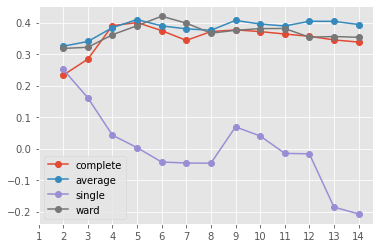

In [25]:
# determine the optimum number of clusters and linkage
n_clusters = np.arange(2, 15)
linkage = ['complete', 'average', 'single', 'ward']
mat = np.zeros((15,4))

for i in n_clusters:
    k = 0
    for j in linkage:        
        ClusterModel = AgglomerativeClustering(n_clusters=i, linkage=j, affinity='euclidean').fit(dfs)
        mat[i,k] = silhouette_score(dfs, ClusterModel.labels_, metric='euclidean')
        k = k+1


# Data Frame
mat_df = pd.DataFrame(mat[1:], columns=['complete', 'average', 'single', 'ward'])

# best params
print('minimum silhouette score in different linkage:\n', round(np.max(mat_df), 3))
print('\nbest linkage:\t', max(mat_df))
print('best number of cluster:\t', np.argmax(mat_df.max(axis=1))+1)

# plots
plt.plot(mat_df.iloc[1:,0], marker = 'o', label = 'complete')
plt.plot(mat_df.iloc[1:,1], marker = 'o', label = 'average')
plt.plot(mat_df.iloc[1:,2], marker = 'o', label = 'single')
plt.plot(mat_df.iloc[1:,3], marker = 'o', label = 'ward')
plt.xticks(mat_df.index, np.arange(1, 16))
plt.legend(loc='best')
plt.show()

The best number of clusters is 6 with *'ward'* linkage for Agglomerative Clustering algorithm.

In [26]:
# fit the model with k = 6 and linkage = 'ward'
np.random.seed(0)
hc_c = AgglomerativeClustering(n_clusters=6, linkage='ward', affinity='euclidean')
km.fit(dfs)

# add predicted clusters to the data 
hc_c_labels = hc_c.fit_predict(dfs)
df['hc_c_cluster'] = hc_c_labels

# number of obs in each cluster
df['hc_c_cluster'].value_counts()

1    45
0    45
2    39
3    28
4    22
5    21
Name: hc_c_cluster, dtype: int64

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'



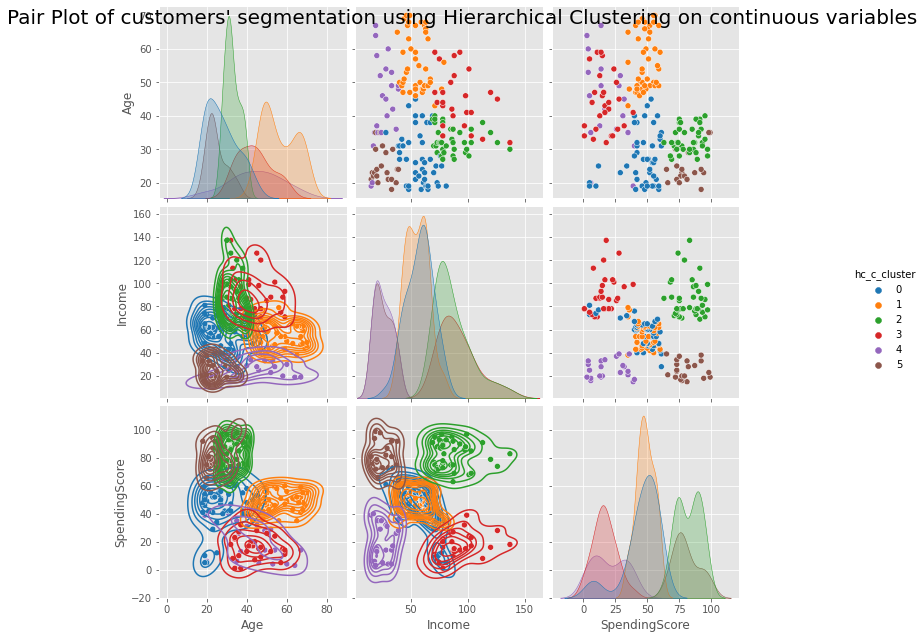

In [27]:
# pair plot on different features, colored by km_cluster
ax = sns.pairplot(df.drop(['km_cluster'], axis=1), hue = 'hc_c_cluster', height = 3, palette='tab10')
ax.map_lower(sns.kdeplot, level=4)
plt.suptitle("Pair Plot of customers' segmentation using Hierarchical Clustering on continuous variables", size = 20)
plt.show()

In [28]:
# 3-D view
fig = px.scatter_3d(data_frame=df, x='Age', y='Income', z='SpendingScore', color='hc_c_cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [29]:
# clusters' characteristics
round(df.groupby(['hc_c_cluster', 'Gender'])[['Age', 'Income', 'SpendingScore']].mean(), 3)

Age  Income  SpendingScore
hc_c_cluster Gender                               
0            Female  29.148  56.889         47.444
             Male    24.722  58.444         43.444
1            Female  55.000  54.500         48.750
             Male    58.000  56.190         47.905
2            Female  32.190  86.048         81.667
             Male    33.278  87.111         82.667
3            Female  43.786  93.286         20.643
             Male    44.000  89.286         12.714
4            Female  41.538  26.538         20.692
             Male    48.333  24.667         19.667
5            Female  25.462  25.692         80.538
             Male    23.750  25.500         79.750

In a nutshell, our six clusters are defined as:
- **Cluster 1**: Men and women around 27.4 years old with average 57.5K annual income and spending score of 45.8 out of 100.
- **Cluster 2**: Men and women around 56.4 years old with average 55.3K annual income and spending score of 48.4 out of 100.
- **Cluster 3**: Men and women around 32.7 years old with average 86.5K annual income and spending score of 82.1 out of 100.
- **Cluster 4**: Men and women around 43.9 years old with average 91.3K annual income and spending score of 16.7 out of 100.
- **Cluster 5**: Men and women around 44.3 years old with average 25.8K annual income and spending score of 20.3 out of 100.
- **Cluster 6**: Men and women around 24.8 years old with average 25.6K annual income and spending score of 80.2 out of 100.

#### 3.1.2.1 on mixed-type data

We know that in mixed-type data like our data set, the most dissimilarity methods like **KMeans** and **Hierarchical Clustering** cannot be applied to this kind of data directly. Gower (1971) and Ichino and Yaguchi (1994) propose some general measures:

In [30]:
# Gower similarity matrix
gsm = gower.gower_matrix(df.drop(['km_cluster', 'hc_c_cluster'], axis=1), cat_features = [True, False, False, False])

Like Hierarchical Clustering on continuous variables, we are interested to know about the best number of clusters and linkage parameter for Agglomerative Clustering algorithm.

"ward" in linkage can only work with euclidean distances. So, When "precomputed" was provided as affinity, we cannot use "ward".

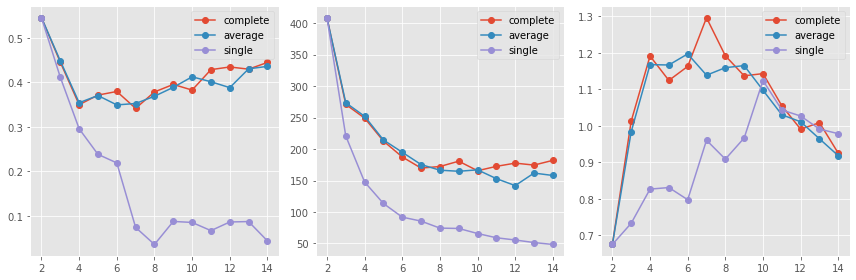

In [31]:
# determine the optimum number of clusters and linkage using silhouette, calinski harabasz, and davies bouldin indices
n_clusters = np.arange(2, 15)
linkage = ['complete', 'average', 'single']  # ward removed
mat1 = np.zeros((15,3))
mat2 = np.zeros((15,3))
mat3 = np.zeros((15,3))


for i in n_clusters:
    k = 0
    for j in linkage:        
        ClusterModel = AgglomerativeClustering(n_clusters=i, linkage=j, affinity='precomputed').fit(gsm)
        mat1[i,k] = silhouette_score(gsm, ClusterModel.labels_, metric='precomputed')
        k = k+1


for i in n_clusters:
    k = 0
    for j in linkage:        
        ClusterModel = AgglomerativeClustering(n_clusters=i, linkage=j, affinity='precomputed').fit(gsm)
        mat2[i,k] = calinski_harabasz_score(gsm, ClusterModel.labels_)
        k = k+1



for i in n_clusters:
    k = 0
    for j in linkage:        
        ClusterModel = AgglomerativeClustering(n_clusters=i, linkage=j, affinity='precomputed').fit(gsm)
        mat3[i,k] = davies_bouldin_score(gsm, ClusterModel.labels_)
        k = k+1



# Data Frame
mat1_df = pd.DataFrame(mat1[1:], columns=['complete', 'average', 'single'])
mat2_df = pd.DataFrame(mat2[1:], columns=['complete', 'average', 'single'])
mat3_df = pd.DataFrame(mat3[1:], columns=['complete', 'average', 'single'])



# plots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].plot(np.arange(2,15), mat1_df.iloc[1:,0], marker = 'o', label = 'complete')
axes[0].plot(np.arange(2,15), mat1_df.iloc[1:,1], marker = 'o', label = 'average')
axes[0].plot(np.arange(2,15), mat1_df.iloc[1:,2], marker = 'o', label = 'single')
axes[0].legend(loc='best')
axes[1].plot(np.arange(2,15), mat2_df.iloc[1:,0], marker = 'o', label = 'complete')
axes[1].plot(np.arange(2,15), mat2_df.iloc[1:,1], marker = 'o', label = 'average')
axes[1].plot(np.arange(2,15), mat2_df.iloc[1:,2], marker = 'o', label = 'single')
axes[1].legend(loc='best')
axes[2].plot(np.arange(2,15), mat3_df.iloc[1:,0], marker = 'o', label = 'complete')
axes[2].plot(np.arange(2,15), mat3_df.iloc[1:,1], marker = 'o', label = 'average')
axes[2].plot(np.arange(2,15), mat3_df.iloc[1:,2], marker = 'o', label = 'single')
axes[2].legend(loc='best')
fig.tight_layout()


# interpret the indices
#silhouette: a value close to 1 is good
#calinski harabasz: the higher, better
# davies bouldin: values closer to zero indicate a better

The best number of clusters is 2 based on the plots.

In [32]:
hc_m = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
hc_m.fit(gsm)

AgglomerativeClustering(affinity='precomputed', linkage='complete')

<ipython-input-33-541751493ed7>:4: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



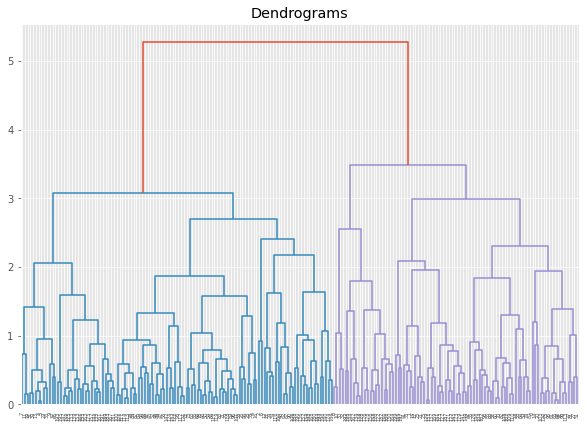

In [33]:
# dendrogram
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(y=gsm, method='complete'))

In [34]:
#predictions from AgglomerativeClustering
hc_m_labels = hc_m.fit_predict(gsm)
df['hc_m_cluster'] = hc_m_labels

# number of obs in each cluster
df['hc_m_cluster'].value_counts()

1    112
0     88
Name: hc_m_cluster, dtype: int64

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'



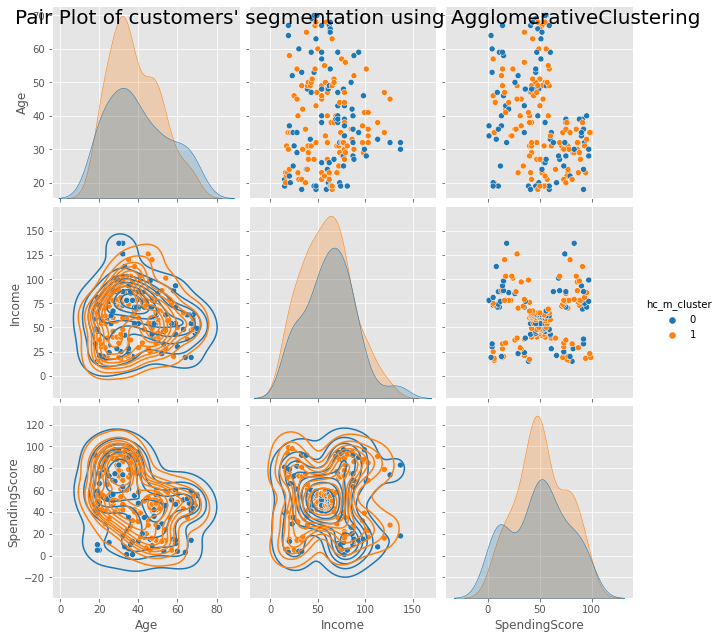

In [35]:
# pair plot on different features, colored by ac_clusters
ax = sns.pairplot(df.drop(['km_cluster', 'hc_c_cluster'],axis=1), hue = 'hc_m_cluster', height = 3, palette='tab10')
ax.map_lower(sns.kdeplot, level=4)
plt.suptitle("Pair Plot of customers' segmentation using AgglomerativeClustering", size = 20)
plt.show()

In [36]:
# 3-D view
fig = px.scatter_3d(data_frame=df, x='Age', y='Income', z='SpendingScore', color='hc_m_cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [37]:
# clusters' characteristics
round(df.groupby(['hc_m_cluster', 'Gender'])[['Age', 'Income', 'SpendingScore']].mean(), 3)

Age  Income  SpendingScore
hc_m_cluster Gender                               
0            Female     NaN     NaN            NaN
             Male    39.807  62.227         48.511
1            Female  38.098  59.250         51.527
             Male       NaN     NaN            NaN

In this case, two clusters are exactly divided by 'Gender' variable. It seems the Gower distance matrix did not work well for our data. So, we will study the mixed-type data with the help of KPrototypes algorithm.

### 3.1.3 KPrototype

One major limit on our project for cluster analysis of mall customers is the existence of a categorical variable in our data. In fact, we have a categorical variable alongside 3 continuous variables. When we are facing mixed-type data sets, dissimilarity methods like KMeans (or even Agglomerative Clustering) is not helpful. In this case, another algorithm was introduced by [Huang (1998)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf), called the KPrototypes algorithm.

The KPrototypes algorithm belongs to the family of dissimilarity methods that comes from the KMeans and k-modes algorithm. k-modes is a kind of algorithm that is used for categorical data sets only.

In the KPrototypes algorithm, the prototype [(Gan 2007)](https://doi.org/10.1137/1.9780898718348) is the center of a cluster, just as the mean and modes are the centers of a cluster in the kMeans and k-modes algorithms, respectively.

In a nutshell,
**KPrototypes** = *KMeans* for continuous variables + *K-modes* for categorical variables.

Like other dissimilarity algorithms, K-prototypes needs standardized variables. Following, we are going to use this algorithm to cluster mixed-type data, and we do not remove Gender thus.

In [38]:
# make a data ftame from normalized continuous variables along categorical
# normalize the continuous variables
df_std = df.drop(['km_cluster', 'hc_c_cluster', 'hc_m_cluster'], axis=1)
scaler = StandardScaler()
df_std[['Age', 'Income', 'SpendingScore']] = scaler.fit_transform(df[['Age', 'Income', 'SpendingScore']])

# convert categorical labels to encode
le = LabelEncoder()
df_std['Gender_encode'] = le.fit_transform(df_std['Gender'])

# drop Gender
df_std = df_std.drop(['Gender'], axis=1)
df_std.head()

Age    Income  SpendingScore  Gender_encode
0 -1.424569 -1.738999      -0.434801              1
1 -1.281035 -1.738999       1.195704              1
2 -1.352802 -1.700830      -1.715913              0
3 -1.137502 -1.700830       1.040418              0
4 -0.563369 -1.662660      -0.395980              0

Our target in to minimize the **cost function** in KPrototypes algorithm. So, the best number of clusters can be determined using cost function.

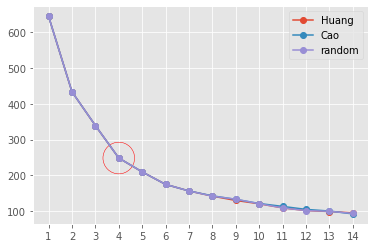

In [39]:
initi = ['Huang', 'Cao', 'random']
cost = np.zeros((15, 3))

for k in np.arange(1, 15):
    j = 0
    for i in initi:
        kpr = KPrototypes(n_clusters=k, init=i).fit(df_std, categorical=[3])
        cost[k, j] = (kpr.cost_)
        j = j+1


# Data Frame
cost_df = pd.DataFrame(cost[1:], columns=['Huang', 'Cao', 'random'])


# plots
plt.plot(cost_df.iloc[:,0], marker = 'o', label = 'Huang')
plt.plot(cost_df.iloc[:,1], marker = 'o', label = 'Cao')
plt.plot(cost_df.iloc[:,2], marker = 'o', label = 'random')
plt.scatter(3, min(cost[4]), facecolor = 'None', edgecolor = 'red',s = 1000)  # identify the best n_cluster
plt.xticks(cost_df.index, np.arange(1, 15))
plt.legend(loc='best')
plt.show()

As we can see from the plots, all initialization methods have the same cost function in each number of clusters.

Additionally, the best number of cluster is when the cost function has no more dramatical reduction. So, the best number of cluster in our problem in 4.

Additionally, we should identify the categorical column index for the algorithm. So, 'Gender' is stored in column index of 3.

In [40]:
kpr = KPrototypes(n_clusters=4, init='Cao')
kpr.fit(df_std, categorical=[3])  # specify which columns are categorical: column 3 are categorical

KPrototypes(gamma=0.5, n_clusters=4)

In [41]:
# cost function of fitted model
kpr.cost_

248.4532171520836

In [42]:
#predictions from KPrototypes
kpr_labels = kpr.fit_predict(df_std, categorical=[3])
df['kpr_cluster'] = kpr_labels

# number of obs in each cluster
df['kpr_cluster'].value_counts()

3    66
1    60
0    40
2    34
Name: kpr_cluster, dtype: int64

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'



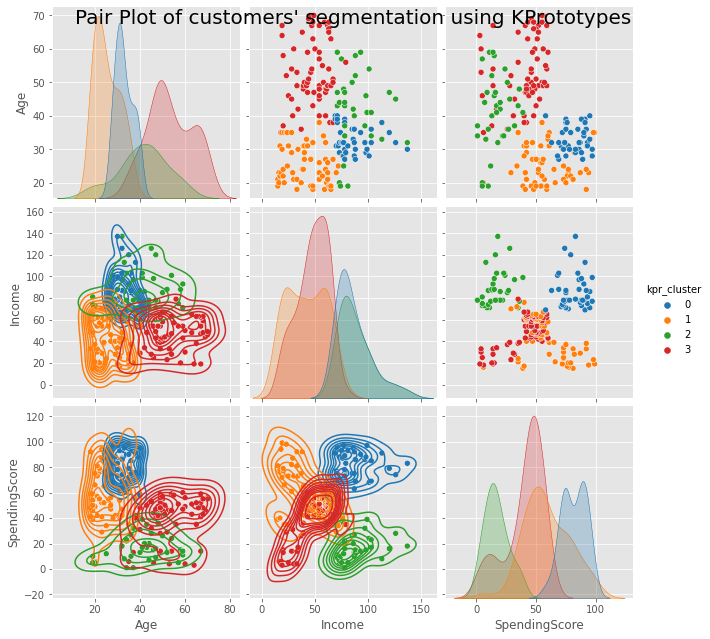

In [43]:
# pair plot on different features, colored by kpr_clusters
ax = sns.pairplot(df.drop(['km_cluster', 'hc_c_cluster', 'hc_m_cluster'], axis=1), hue = 'kpr_cluster', height = 3, palette='tab10')
ax.map_lower(sns.kdeplot, level=4)
plt.suptitle("Pair Plot of customers' segmentation using KPrototypes", size = 20)
plt.show()

In [44]:
# 3-D view
fig = px.scatter_3d(data_frame=df, x='Age', y='Income', z='SpendingScore', color='kpr_cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [45]:
# clusters' characteristics
round(df.groupby(['kpr_cluster', 'Gender'])[['Age', 'Income', 'SpendingScore']].mean(), 3)

Age  Income  SpendingScore
kpr_cluster Gender                               
0           Female  32.545  85.273         80.591
            Male    33.278  87.111         82.667
1           Female  25.946  42.216         57.459
            Male    24.609  40.696         61.478
2           Female  43.786  93.286         20.643
            Male    39.500  85.150         14.050
3           Female  50.718  48.513         40.590
            Male    57.333  47.000         40.222

In a nutshell, our four clusters are defined as:
- **Cluster 1**: Men and women around 32.9 years old with average 86.1K annual income and spending score of 81.5 out of 100.
- **Cluster 2**: Men and women around 25.4 years old with average 41.6K annual income and spending score of 59.0 out of 100.
- **Cluster 3**: Men and women around 41.3 years old with average 88.5K annual income and spending score of 16.8 out of 100.
- **Cluster 4**: Men and women around 53.4 years old with average 47.0K annual income and spending score of 40.4 out of 100.

### 3.1.4 Summary findings in Dissimilarity methods

While the most dissimilarity algorithms are able to deal with one type of data sets (continuous or categorical), KPrototypes overcomes mixed-type data.

Likewise, when we face mixed-type data, one may prefer to remove categorical variables to use KMeans or Hierarchical clustering. One may convert a continuous variable to a categorical (e.g. 'Age' to 'Group of Age') in order to have one type of data and use K-modes for all categorical data. The K-prototypes algorithm was introduced to deal with mixed-type data if we want to use dissimilarity methods.

Our data was clustered nicely without removing the 'Gender' variable. The KPrototypes identified **4** various clusters with a different type of 'Gender' in each cluster, whereas KMeans and Hierarchical clustering (with **6** clusters) were unable to consider 'Gender' in our cluster analysis.

## 3.2 Model-based method

### 3.2.1 GMM with EM Algorithm

Gaussian Mixture Model (GMM) assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together. GMM has latent variables that are mean and variance of the model. These values are determined using Expectation-Maximization (EM) algorithm. EM algorithm tries to use the existing data to determine the optimum values for these variables and then finds the model parameters. Based on these model parameters, we go back and update the values for the latent variable, and so on.

Broadly, the Expectation-Maximization algorithm has two steps:

- E-step: In this step, the available data is used to estimate (guess) the values of the missing variables
- M-step: Based on the estimated values generated in the E-step, the complete data is used to update the parameters

Gaussian distributions are continuous distributions.
There is no meaningful way to apply it onto categorical data. So, we have to move forward with continuous variables.

Moreover, the Bayesian information criterion (BIC) is used to assess the fit of a model. BIC is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.

In [46]:
# continuous variables
df_c = df[['Age', 'Income', 'SpendingScore']]

minimum BIC in different covariance type:
 full         5236.304
tied         5237.218
diag         5181.262
spherical    5236.406
dtype: float64

best covariance type:	 diag
best number of component:	 5


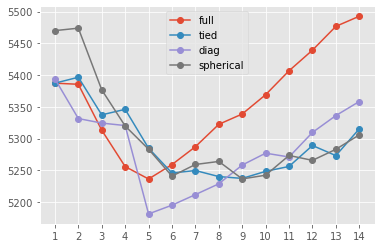

In [47]:
# determine the optimum number of components and covariance type
np.random.seed(0)
n_components = np.arange(1, 15)
covariance_type = ['full', 'tied', 'diag', 'spherical']
mat = np.zeros((15,4))

for i in n_components:
    k = 0
    for j in covariance_type:        
        gmm_ts = GaussianMixture(n_components=i, covariance_type=j).fit(df_c)
        mat[i,k] = gmm_ts.bic(df_c)
        k = k+1

# Data Frame
bic_df = pd.DataFrame(mat[1:], columns=['full', 'tied', 'diag', 'spherical'])

# best params
print('minimum BIC in different covariance type:\n', round(np.min(bic_df), 3))
print('\nbest covariance type:\t', min(bic_df))
print('best number of component:\t', np.argmin(bic_df.min(axis=1))+1)

# plots
plt.plot(bic_df.iloc[:,0], marker = 'o', label = 'full')
plt.plot(bic_df.iloc[:,1], marker = 'o', label = 'tied')
plt.plot(bic_df.iloc[:,2], marker = 'o', label = 'diag')
plt.plot(bic_df.iloc[:,3], marker = 'o', label = 'spherical')
plt.xticks(bic_df.index, np.arange(1, 15))
plt.legend(loc='best')
plt.show()

We also can use **silhouette**, **calinski harabasz**, and **davies bouldin** indices to determine the best number of components/clusters.

The result shows that all indices prove the result from **BIC** to find the optimum number of components/clusters.

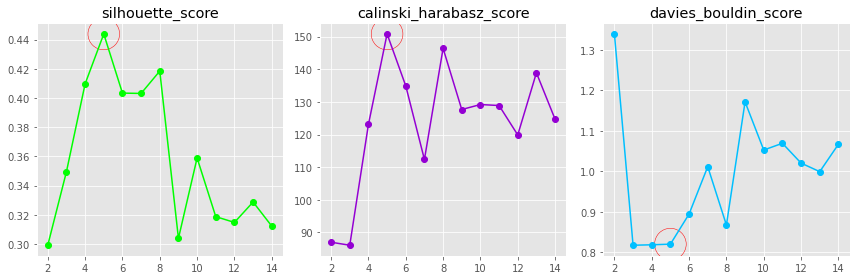

In [48]:
# determine best number of clusters using silhouette, calinski harabasz, and davies bouldin indices
np.random.seed(0)
Score1 = []
Score2 = []
Score3 = []

for k in range(2, 15):
    ClusterModel = GaussianMixture(n_components=k, covariance_type='diag').fit(df_c)
    Score1.append(silhouette_score(df_c, ClusterModel.predict(df_c)))
    Score2.append(calinski_harabasz_score(df_c, ClusterModel.predict(df_c)))
    Score3.append(davies_bouldin_score(df_c, ClusterModel.predict(df_c)))


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].plot(range( 2 ,15), Score1, marker='o', c='lime')
axes[0].scatter(5, Score1[3], facecolor = 'None', edgecolor = 'red',s = 1000)
axes[0].set_title('silhouette_score')

axes[1].plot(range( 2 ,15), Score2, marker='o', c='darkviolet')
axes[1].scatter(5, Score2[3], facecolor = 'None', edgecolor = 'red', s = 1000)
axes[1].set_title('calinski_harabasz_score')

axes[2].plot(range( 2 ,15), Score3, marker='o', c='deepskyblue')
axes[2].scatter(5, Score3[3], facecolor = 'None', edgecolor = 'red', s = 1000)
axes[2].set_title('davies_bouldin_score')
fig.tight_layout()



# interpret the indices
#silhouette: a value close to 1 is good
#calinski harabasz: the higher, better
# davies bouldin: values closer to zero indicate a better

As we can see from the plots, while "diag" is the best covariance method, 5 components/clusters is also the best choice.

In [49]:
# fit the model
gmm = GaussianMixture(n_components=5, covariance_type='diag')
gmm.fit(df_c)

GaussianMixture(covariance_type='diag', n_components=5)

In [50]:
# BIC for the fitted model
print('BIC: ', gmm.bic(df_c))

BIC:  5181.254222588742


In [51]:
# number of EM iterations
print('The number of EM iterations to get converged: ', gmm.n_iter_)

The number of EM iterations to get converged:  3


In [52]:
#predictions from GMM
labels = gmm.predict(df_c)
df['gmm_cluster'] = labels

In [53]:
df.head()

Gender  Age  Income  SpendingScore  km_cluster  hc_c_cluster  hc_m_cluster  \
0    Male   19      15             39           1             4             0   
1    Male   21      15             81           1             5             0   
2  Female   20      16              6           5             4             1   
3  Female   23      16             77           1             5             1   
4  Female   31      17             40           5             4             1   

   kpr_cluster  gmm_cluster  
0            1            1  
1            1            4  
2            1            1  
3            1            4  
4            1            1

In [54]:
print('Class Weights:\n', gmm.weights_)
print('\nClass mean:\n', gmm.means_)

Class Weights:
 [0.19572174 0.1116969  0.39423143 0.18676665 0.11158327]

Class mean:
 [[32.69188924 86.40679498 82.05621118]
 [44.82417847 25.99380702 20.6530236 ]
 [43.2178764  54.77890136 49.70921739]
 [40.58149499 87.02328086 18.30934453]
 [25.34115869 25.95615044 79.0120721 ]]


In [55]:
# number of obs in each cluster
df['gmm_cluster'].value_counts()

2    78
0    39
3    38
1    23
4    22
Name: gmm_cluster, dtype: int64

GMM contains a probabilistic model under the hood. So, it is possible to find probabilistic cluster assignments.

In [56]:
# probabilistic cluster assignments
prob_clusters = gmm.predict_proba(df_c)
uncer = np.zeros(200)

for i in range(0, len(prob_clusters)):
    uncer[i] = (prob_clusters[i][np.where(prob_clusters[i]<0.95)[0]]).sum()

print('Observations with uncertainity of more than 0.05:\n', list(np.where(uncer>0.05)[0]))
print('\nTotally, %d observations have the uncertainity of more than 0.05' % len(list(np.where(uncer>0.05)[0])))

Observations with uncertainity of more than 0.05:
 [27, 40, 42, 43, 44, 45, 48, 49, 51, 121, 126, 132, 142, 146]

Totally, 14 observations have the uncertainity of more than 0.05


In [57]:
for i in [0, 0.25, 0.5, 0.75]:
    #print('Quantile-', i, '%\n', np.quantile(gmm.predict_proba(df_c), i))
    np.quantile(gmm.predict_proba(df_c), i)

The uncertainty associated with conditional probabilities z can be obtained by subtracting the probability of the most likely group for each observation from 1. We found that 14 observations have an uncertainty of more than 0.05. The quantile shows that the vast majority of observations have certainty in their clusters.

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'

C:\Users\mosta\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning:

The following kwargs were not used by contour: 'level'



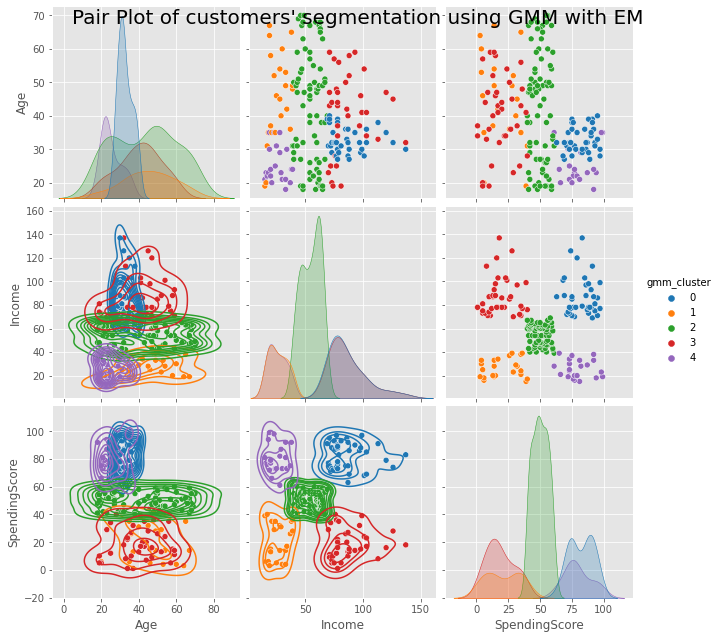

In [58]:
# pair plot on different features, colored by clusters
g=sns.pairplot(df.drop(['km_cluster', 'hc_c_cluster', 'hc_m_cluster', 'kpr_cluster'], axis=1),
               hue = 'gmm_cluster', height = 3, palette='tab10')
g.map_lower(sns.kdeplot, level=4)
plt.suptitle("Pair Plot of customers' segmentation using GMM with EM", size = 20)
plt.show()

In [59]:
fig = px.scatter_3d(data_frame=df, x='Age', y='Income', z='SpendingScore', color='gmm_cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [60]:
# clusters' characteristics
round(df.groupby(['gmm_cluster'])[['Age', 'Income', 'SpendingScore']].mean(), 3)

Age  Income  SpendingScore
gmm_cluster                               
0            32.692  86.538         82.128
1            45.217  26.304         20.913
2            43.128  54.615         50.026
3            40.395  87.000         18.632
4            25.273  25.727         79.364

In a nutshell, our five clusters are defined as:
- **Cluster 1**: Men and women around 32.7 years old with average 86.5K annual income and spending score of 82.1 out of 100.
- **Cluster 2**: Men and women around 45.2 years old with average 26.3K annual income and spending score of 20.9 out of 100.
- **Cluster 3**: Men and women around 43.1 years old with average 54.6K annual income and spending score of 50.0 out of 100.
- **Cluster 4**: Men and women around 40.4 years old with average 87.0K annual income and spending score of 18.6 out of 100.
- **Cluster 5**: Men and women around 25.3 years old with average 25.7K annual income and spending score of 79.4 out of 100.

### 3.2.2 Summary findings in GMM with EM algorithm

For our given set of data points, our GMM identified the probability of each data point belonging to 5 different distributions. Since we do not have the values for the latent variables, Expectation-Maximization tried to use the existing data to determine the optimum values for these variables and then found the model parameters. In addition, the major difference between dissimilarity methods and model-based method is the fact that dissimilarity methods only consider the mean to update the centroid while GMM considers the mean as well as the variance of the data. Our findings represent different number of customers in each cluster with different characteristics. Proportion of clusters seem common through all methods, and all clusters are quite different from each other.